In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson3D
problem = Poisson3D()

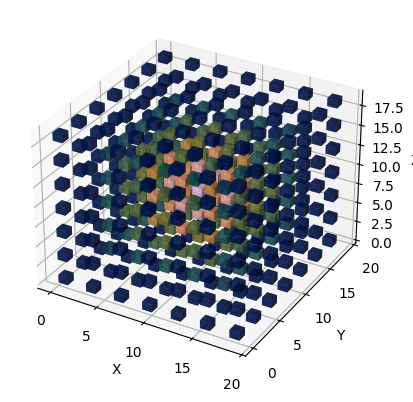

In [3]:
X, Y, Z, u_solution = problem.exact_solution(nx=7, ny=7, nz=7)

def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = u_solution.shape[0]
y_num = u_solution.shape[1]
z_num = u_solution.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(u_solution)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [4]:
X, Y, Z, u_solution = problem.exact_solution(nx=32, ny=32, nz=32)

# Optimiser

In [5]:
class HistoryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 5.0,
        increase_factor: float = 1.5,
        max_trials: int = 20,
        history_size: int = 10,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials
        self.history_size = history_size

    def init(self, params: eqx.Module):
        """Initialises the optimiser's state."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.history_size,), jnp.inf),
            'count': jnp.zeros((), dtype=jnp.int32),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        """Performs a single optimisation step."""
        
        current_lambda = state["lambda"]
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        
        # --- Update history and get the 'high-water mark' reference loss ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        # --- JVP/VJP setup for the matrix-free CG solver ---
        # The VJP function can be created once and reused.
        # It's used to compute J^T @ v products.
        _, vjp_fn = jax.vjp(flat_residual_fn, params_flat)
        
        # This is the right-hand side of the normal equation: b = -J^T @ r
        b = -vjp_fn(residuals)[0]

        # --- JAX's while_loop to find an acceptable step ---
        # The loop state carries: (lambda_candidate, accepted, count, final_delta, final_loss)
        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count, _, _ = loop_val
            
            # --- Define the function for the matrix-vector product A@v ---
            # where A = (J^T @ J + lambda * I)
            def mat_vec_product(v: jax.Array) -> jax.Array:
                # 1. Compute J @ v (a JVP)
                _, jvp_val = jax.jvp(flat_residual_fn, (params_flat,), (v,))
                # 2. Compute J^T @ (J @ v) (a VJP)
                jT_jvp_val = vjp_fn(jvp_val)[0]
                # 3. Add the damping term
                return jT_jvp_val + trial_lambda * v

            # --- Solve for delta using Conjugate Gradient ---
            # Solves (J^T @ J + lambda * I) @ delta = -J^T @ r
            delta, _ = jax.scipy.sparse.linalg.cg(
                mat_vec_product, b, tol=1e-5
            )
            
            # Note: eqx.apply_updates is preferred over manual addition for safety
            trial_params_flat = params_flat + delta
            trial_residuals = flat_residual_fn(trial_params_flat)
            trial_loss = jnp.mean(trial_residuals**2)
            
            # THE ROBUST NON-MONOTONIC CHECK
            accepted = trial_loss < reference_loss
            
            # Update lambda for the *next* iteration based on outcome
            # Use a nested cond for the two-stage acceptance logic
            new_lambda = jax.lax.cond(
                accepted,
                lambda: jax.lax.cond(
                    trial_loss < current_loss, # True descent
                    lambda: trial_lambda / self.decrease_factor,
                    lambda: trial_lambda / (self.decrease_factor * 0.5) # Non-monotonic accept
                ),
                lambda: trial_lambda * self.increase_factor # Rejected
            )
            
            return new_lambda, accepted, trial_count + 1, delta, trial_loss

        def continue_search(loop_val):
            _, accepted, trial_count = loop_val[:3]
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # Initial loop state
        init_loop_val = (current_lambda, False, 0, jnp.zeros_like(params_flat), jnp.inf)
        
        # Run the loop
        final_lambda, step_was_accepted, _, final_delta, final_loss = jax.lax.while_loop(
            continue_search, evaluate_trial_step, init_loop_val
        )
        
        updates = unflatten(final_delta)
        new_state = {
            'lambda': final_lambda,
            'loss_history': new_loss_history,
            'count': state["count"] + 1
        }

        metrics = { 
            'loss': current_loss,
            'final_loss': final_loss,
            'step_accepted': step_was_accepted,
            'lambda': final_lambda,
            'reference_loss': reference_loss,
            'search_direction_norm': jnp.linalg.norm(final_delta),
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [6]:
class GeneralisedLevenbergMarquardt:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 1.5,
        increase_factor: float = 1.5,
        used_factor: float = 1.0,
        max_trials: int = 500,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.used_factor = used_factor
        self.max_trials = max_trials

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {'lambda': self.init_lambda}

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        # --- JVP/VJP setup for the matrix-free CG solver ---
        # The VJP function is created once to compute J^T @ v products.
        _, vjp_fn = jax.vjp(flat_residual_fn, params_flat)
        
        # This is the right-hand side of the normal equation: b = -J^T @ r
        # It's constant throughout the lambda search loop.
        b = -vjp_fn(residuals)[0]

        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count = loop_val
            
            # --- Define the mat-vec product A@v for the trial step ---
            # where A = (J^T @ J + lambda * I)
            def mat_vec_product(v: jax.Array) -> jax.Array:
                _, jvp_val = jax.jvp(flat_residual_fn, (params_flat,), (v,))
                jT_jvp_val = vjp_fn(jvp_val)[0]
                return jT_jvp_val + trial_lambda * v

            # --- Solve for the trial delta using Conjugate Gradient ---
            delta, _ = jax.scipy.sparse.linalg.cg(
                mat_vec_product, b, tol=1e-5
            )

            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = residual_fn(trial_params)
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = trial_loss < current_loss
            
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda / self.decrease_factor,
                lambda: trial_lambda * self.increase_factor
            )
            
            return new_lambda, accepted, trial_count + 1

        def continue_until_accepted(loop_val):
            # Continue if step is not accepted AND we haven't exceeded max trials
            _, accepted, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # --- Run the loop to find an acceptable step and lambda ---
        final_lambda, step_was_accepted, _ = jax.lax.while_loop(
            continue_until_accepted, evaluate_trial_step, (current_lambda, False, 0)
        )

        # --- Re-calculate the final delta using the accepted lambda ---
        final_adjusted_lambda = final_lambda * self.decrease_factor * self.used_factor
        
        def final_mat_vec_product(v: jax.Array) -> jax.Array:
            _, jvp_val = jax.jvp(flat_residual_fn, (params_flat,), (v,))
            jT_jvp_val = vjp_fn(jvp_val)[0]
            return jT_jvp_val + final_adjusted_lambda * v

        final_delta, _ = jax.scipy.sparse.linalg.cg(
            final_mat_vec_product, b, tol=1e-5
        )
        
        updates = unflatten(final_delta)
        new_state = {'lambda': final_lambda}

        metrics = { 
            'loss': current_loss,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
        }

        return current_loss, updates, new_state, metrics

In [ ]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [3, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

aggr_optimiser = GeneralisedLevenbergMarquardt(
    decrease_factor=1.5,
    increase_factor=1.1,
    used_factor=0.9,
    init_lambda=1e-3,
)
aggr_opt_state = aggr_optimiser.init(params)

optimiser = HistoryLM(
    init_lambda=1e6,
    decrease_factor=1.25,
    increase_factor=1.1,
    max_trials=50,
    history_size=10,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

print(f"Starting PINN training with {type(aggr_optimiser).__name__}...")
for epoch in range(300):
    params, aggr_opt_state, loss_val, metrics = train_step(
        params, static, aggr_opt_state, aggr_optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")


print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(300):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with GeneralisedLevenbergMarquardt...
Epoch 20, Loss: 1.198e+02, Time elapsed: 85.42 s
Epoch 40, Loss: 8.169e+00, Time elapsed: 301.92 s
Epoch 60, Loss: 2.098e-02, Time elapsed: 1763.79 s
Epoch 80, Loss: 1.276e-02, Time elapsed: 2828.54 s
Epoch 100, Loss: 2.310e-02, Time elapsed: 3599.41 s
Epoch 120, Loss: 8.025e-03, Time elapsed: 5121.01 s
Epoch 140, Loss: 5.101e-03, Time elapsed: 6773.22 s


In [ ]:
u_pred = model.predict(X, Y, Z)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 3.574e-05


In [ ]:
error2 = error[::5, ::5, ::5]
print(error2.shape)

(7, 7, 7)


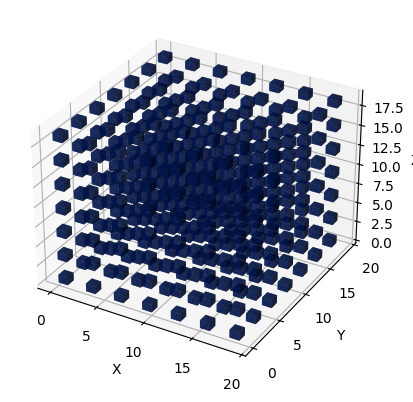

In [ ]:
def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = error2.shape[0]
y_num = error2.shape[1]
z_num = error2.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(error2)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

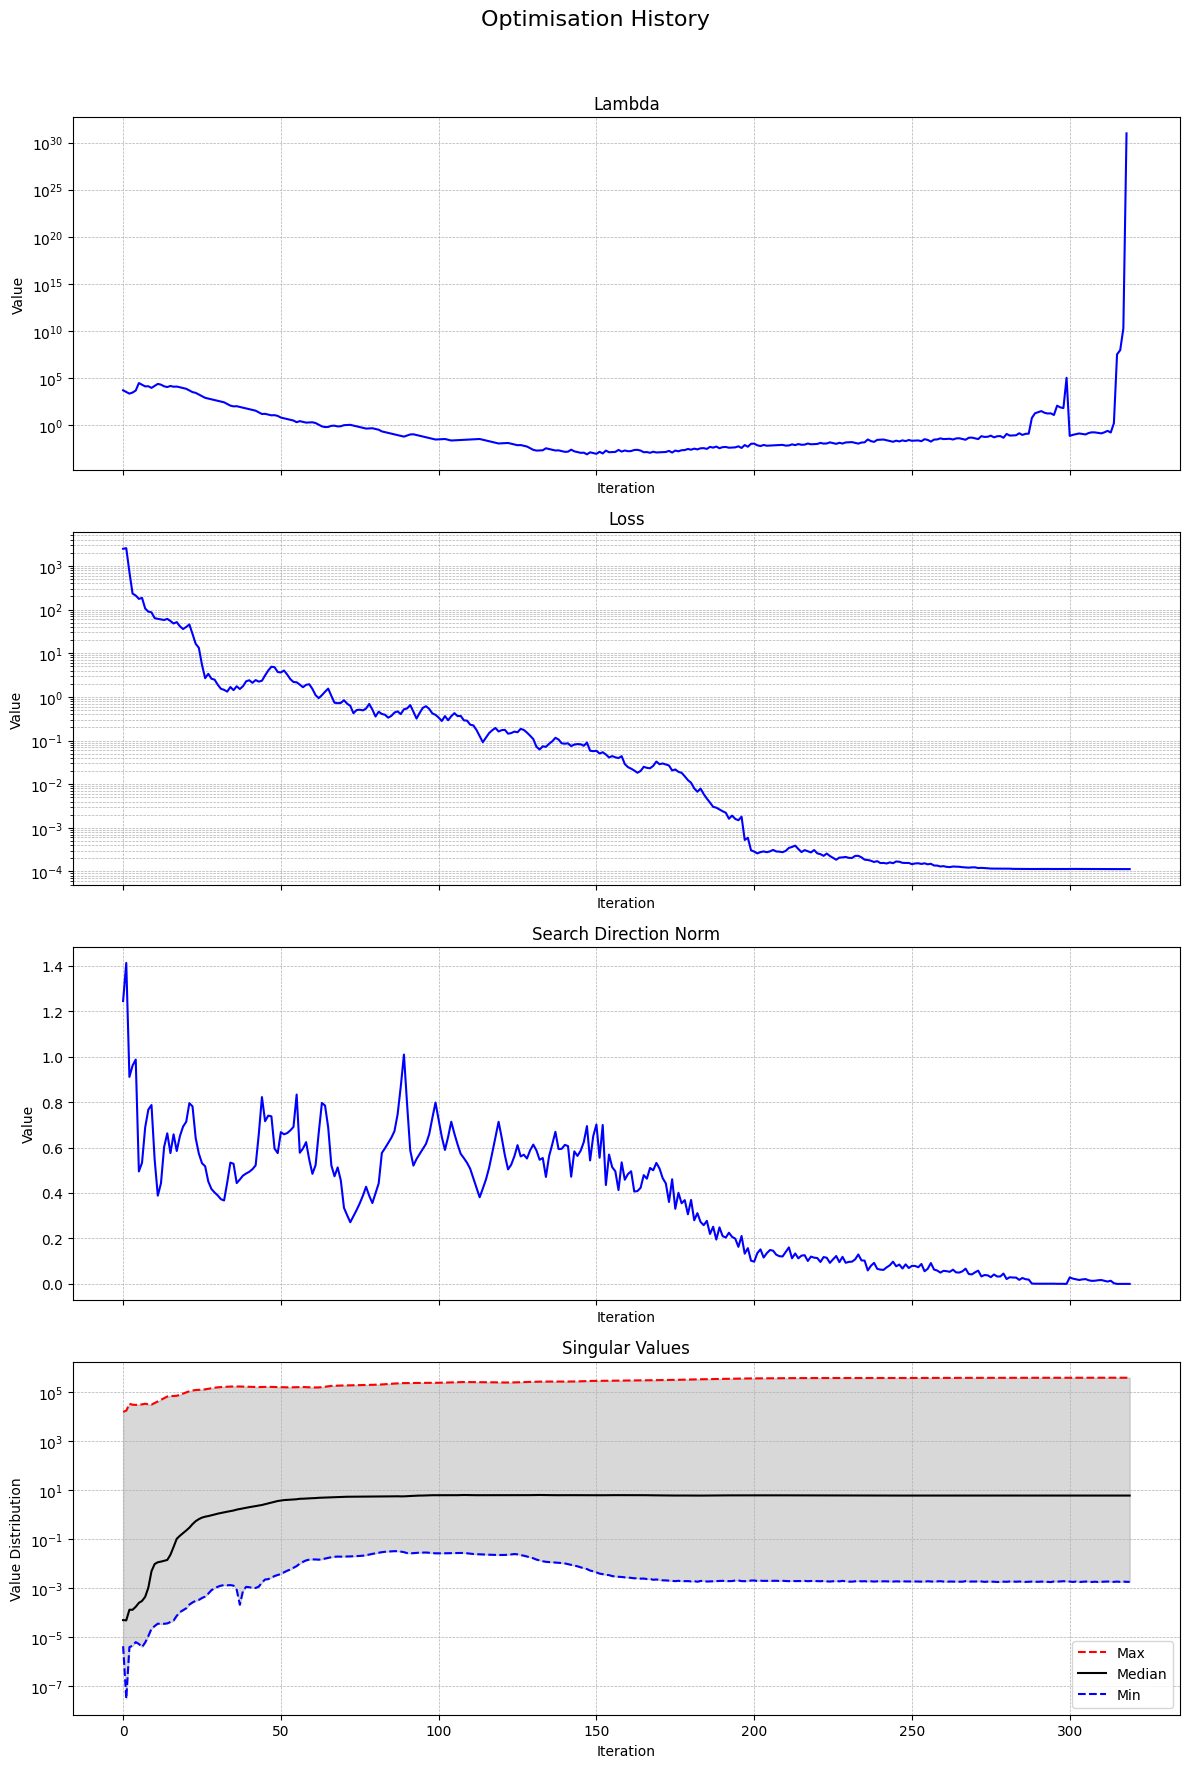

In [ ]:
history.plot()